# Data

In [1]:
import os
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from fetch_data import get, get_KS
from sklearn.metrics import roc_curve
import sklearn.preprocessing as pre
import sklearn
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from pyts.image import GramianAngularField as GAF
from pyts.image import MarkovTransitionField as MTF
from tensorflow.keras import metrics
from sklearn.metrics import auc, roc_curve

%matplotlib inline

In [3]:
# read the data and split into train, validation and test

train, val, test = get(train_size=0.85, val_size=0.05, test_size=0.1)

# KNN

# CNN+LSTM

In [4]:
train_seq, train_non, train_Y = train

In [5]:
values=np.concatenate([np.unique(train_seq[:,:,0]),np.unique(train_seq[:,:,0])+100\
       ,np.unique(train_seq[:,:,0])+1000,np.unique(train_seq[:,:,0])+1100,np.unique(train_seq[:,:,0])-100\
                      ,np.unique(train_seq[:,:,0])-1000\
                      ,np.unique(train_seq[:,:,0])-1100],axis=0)

In [6]:
fitter = pre.LabelEncoder()
fitter.fit(values[:, np.newaxis])

C:\Users\Harry\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [7]:
fitter.transform(values)

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
      dtype=int64)

In [8]:
fitter.transform

<bound method LabelEncoder.transform of LabelEncoder()>

In [9]:
def Labelhotter(data,fitter):
    '''
    combining pid, sid, page_type into one kind of label
    combining together and then every value in the output represent a status of (page_type, pid, sid)
    '''
    trans=data[:,:,0]+data[:,:,-1]*1000+data[:,:,-2]*100
    store=[]
    for i in range(60):
        store.append(np.array(fitter.transform(trans[:,i]))[:,np.newaxis])
    store=np.concatenate(store,axis=1)
    
    
    return np.concatenate([store[:,:,np.newaxis],data[:,:,14:-2]],axis=-1)

In [10]:
Labelhotter(train_seq[:100],fitter=fitter).shape

(100, 60, 3)

In [11]:
def non_onehot(data,size):
    return data
t=pre.OneHotEncoder()
train_Y=(t.fit_transform(train_Y[:,np.newaxis])).todense()

In [12]:
train_seq=non_onehot(train_seq,14)

In [13]:
train_seq.shape,train_non.shape,train_Y.shape

((3157, 60, 18), (3157, 14), (3157, 2))

In [14]:
val_seq,val_non,val_Y=val
val_seq=non_onehot(val_seq,14)
val_Y=(t.fit_transform(val_Y[:,np.newaxis])).todense()
val_seq.shape,val_non.shape,val_Y.shape

((185, 60, 18), (185, 14), (185, 2))

In [15]:
class CNN_LSTM:
    def __init__(self,data,data_non_seq,features,bins_list,size,strategy,label,fitter,name=None):
        '''
        data: training data, sequential data
        data_non_seq: training data, non_sequential data
        bins_list: the bins you want for different features when generating MTF
        features: the number of features you feed into the model
        size: fig_size for MTF and GAF ( not apply in this project since we only use LSTM)
        strategy: the strategy for generating MTF, usually use normal
        label: the training label, Y
        
        Here, CNN_ stands for embedding
        '''

        self.size=size
        self.strategy=strategy
        self.true_features=features
        self.bins_list=bins_list
        self.label=label
        self.fitter=fitter
        
        tp_shape=data_non_seq.shape
        self.non_seq_shape=(tp_shape[1],)
        
        testing=self.transform_used(100,data,data_non_seq,label=self.label)
        tp_shape=(next(testing)[0]).shape
        self.img_shape=(tp_shape[1],)
        
        
        self.CNN=self.CNN_embedding()
        self.LSTM=self.LSTM_()
        self.non_sequential_NN=self.non_sequential_NN_()
        if name:
            self.complete_model=keras.models.load_model(name)
        else:    
            self.complete_model=self.whole_model()
            
#         self.complete_model=self.whole_model()
        
        optimizer=keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
#         optimizer=keras.optimizers.Adagrad(learning_rate=0.0001)
        self.CNN.trainable=True
        self.LSTM.trainable=True
        self.non_sequential_NN.trainable=True
        self.complete_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

#         metrics : for storing the models. only when the model has higher KS and higher AUC in validation 
#         dataset, will we store the model for later use        
        self.metrics=[0,0,0,0,0]
    
    
    
    def transform_used(self,batch_size,data_used,data_non,label,\
                       random_or_not=True,train=True):
        '''
        data_used: sequentila data 
        data_non: non_sequential data
        label: label for training
        random_or_not:False, not random, True, will shuffle it. 
        this will be important when you are not training data. Since we will sometimes use this 
        function generating data for prediction. And the label will then can be randomly assigned
        
        output: data for embedding layer; non_sequential data, time-series data for LSTM, label 
        '''    
        X_train=data_used

#         for epoch in range(epochs):
        whole=len(X_train)//batch_size+(len(X_train)%batch_size!=0)
        total_loss=0
        
        idx=np.arange(len(data_used))
        if random_or_not:
            np.random.shuffle(idx)
        else:
            pass
        for step in range(whole):
            imgs=X_train[idx[step*batch_size:(step+1)*batch_size]]
#                 get the whole transformed_data
         
            non_seq_data=data_non[idx[step*batch_size:(step+1)*batch_size]]
        
            using_data=X_train[idx[step*batch_size:(step+1)*batch_size]]
            
            data_seq_lstm=Labelhotter(using_data,self.fitter)
            seq_data=data_seq_lstm[:,:,0]
            lstm_data=using_data[:,:,1:]
            
            return_label=label[idx[step*batch_size:(step+1)*batch_size]]
            
            yield(seq_data,non_seq_data,lstm_data,return_label)

    def CNN_embedding(self):
        '''
        keras model. CNN
        '''
        dropout=0.5
        
        model=keras.Sequential()
        
        model.add(keras.layers.Embedding(input_dim=84,output_dim=256,input_length=60,input_shape=self.img_shape\
                                        ,trainable=True))
        model.add(keras.layers.Reshape((256,60,1)))
        
        model.add(keras.layers.Conv2D(filters=32,kernel_size=4,strides=(2,1),padding='same',activation='relu'))
        model.add(keras.layers.AveragePooling2D(pool_size=4,strides=(2,1),padding='same'))        
        model.add(keras.layers.Conv2D(filters=1,kernel_size=4,strides=(2,1),padding='same',activation='relu'))
        model.add(keras.layers.AveragePooling2D(pool_size=4,strides=(2,1),padding='same'))
        model.add(keras.layers.Reshape((16,60)))
        
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="tanh",\
                                                                return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
                  
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(16, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=64,activation="relu"))

        img=keras.Input(shape=self.img_shape)
        val=model(img)
        
        model.summary()
        return keras.Model(img,val)
            
        
    def LSTM_(self):
        '''
        LSTM keras model, try to handel original data     
        adding 1-D convolution first
        
        
        '''
        from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
        
        timesteps=60
        n_features=17
        model=keras.Sequential()
        model.add(keras.layers.Conv1D(filters=64,kernel_size=4,padding='same',activation='relu',strides=1\
                                     ,input_shape=(timesteps,n_features)))
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="tanh",\
                                                                return_sequences=True)))
#         model.add(Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
                  
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=64,activation="relu"))
        
        inp=keras.Input(shape=(timesteps,n_features))
        out=model(inp)
        model.summary()
        return keras.Model(inp,out)
    
    
        
        
    def non_sequential_NN_(self):
        '''
        Neural network for NN
        '''
        dropout=0.5
        n_features=self.non_seq_shape
        model=keras.Sequential()
        model.add(keras.layers.Dense(128,activation="relu",input_shape=n_features))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        
        model.add(keras.layers.Dense(64,activation="relu"))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        
        model.add(keras.layers.Dense(64,activation="relu"))
#         
        inp=keras.Input(shape=n_features)
        out=model(inp)
        model.summary()
        return keras.Model(inp,out)
        
        
    def whole_model(self):
        '''
        putting all models together
        '''
        dropout=0.5
        seq_inp=keras.Input(shape=self.img_shape)
        non_inp=keras.Input(shape=self.non_seq_shape)
        LSTM_inp=keras.Input(shape=(60,17))
        
        seq=self.CNN(seq_inp)
        non_seq=self.non_sequential_NN(non_inp)
        rnn=self.LSTM(LSTM_inp)
        
#         model=keras.Sequential()
        concat_=keras.layers.concatenate([seq,non_seq,rnn])
#         concat_=non_seq
        flat=keras.layers.Flatten()(concat_)
        act1=keras.layers.Dense(128,activation="relu")(flat)
        norm1=keras.layers.BatchNormalization()(act1)
        drop1=keras.layers.Dropout(dropout)(norm1)
        
#         act2=keras.layers.Dense(64,activation="relu")(drop1)
#         drop2=keras.layers.Dropout(dropout)(act2)
        
        act3=keras.layers.Dense(16,activation="relu")(drop1)
        norm3=keras.layers.BatchNormalization()(act3)
        drop4=keras.layers.Dropout(dropout)(norm3)
        
        out=keras.layers.Dense(2,activation="softmax")(drop4)
        
        model=keras.Model(inputs=[seq_inp,non_inp,LSTM_inp],outputs=out)
        model.summary()
        return model
    
    def training(self,epochs,batch_size,show_epoch,data,data_non,label,\
                 val_seq,val_non,val_Y,path=None):
        
        data_used=data
        for epoch in range(epochs):
            gener=self.transform_used(batch_size,data,data_non,label)
            whole=len(data_used)//batch_size+(len(data_used)%batch_size!=0)
            total_loss=0
            mean_accuracy=0

            for step in range(whole):
                imgs,non_seq_data,lstm_data,label_batch=next(gener)
                loss=self.complete_model.fit([imgs,non_seq_data,lstm_data],label_batch,batch_size=batch_size,epochs=1,verbose=0)
#                 self.complete_model.train_on_batch()
#                 total_loss+=(loss.loss[0]/whole)
#                 mean_accuracy+=(loss.loss[1]/whole)

            if epoch%show_epoch==0:
                
                predict_prob,predict=self.model_predict(model=self.complete_model,data_seq=val_seq,data_non=val_non,\
                                               batch_size=100)
                val_acc=np.mean(predict==val_Y[:,1])
                _,val_KS=get_KS(predict_prob[:,1],val_Y[:,1])
                fpr,tpr,threshold=roc_curve(val_Y[:,1],predict_prob[:,1])
                val_auc=auc(fpr,tpr)
                self.saver(name="../../data/models/binary_classification_model/"+"embedding_LSTM_FC1_show1_epoch"+str(epoch)+".h5",model=self.complete_model,\
                          metrics=[val_KS,val_auc])
                
#                 print("training on epoch: {}, loss is {}".format(epoch,total_loss))
#                 print("training on epoch: {}, accuracy is {}".format(epoch,mean_accuracy))
                print("training on epoch: {}, validation accuracy is {}".format(epoch,val_acc))
                print("training on epoch: {}, validation KS is {}".format(epoch,val_KS))
                print("training on epoch: {}, validation AUC is {}".format(epoch,val_auc))
                print("balance_status of validation set have {} of ones in val".format(np.sum(val_Y[:,1])/len(val_Y)))
                
                fpr, tpr, threshold = roc_curve(val_Y[:,1],predict_prob[:,1])                
                plt.title('ROC')
                plt.plot(fpr, tpr, 'b')
                plt.legend(loc = 'lower right')
                plt.plot([0, 1], [0, 1],'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.show()
                
                
#                 a=self.sample_images(X=X,epoch=epoch)
                print("------------generate form-------------------------------------------")
                print("--------------------------------------------------------------------")
                
        
    def saver(self,name,model,metrics=None):
        if metrics==None:
            model.save(name)
        else:
            if (metrics[0]>self.metrics[0]) and (metrics[1]>self.metrics[1]):
                model.save(name)
                self.metrics=metrics
                print("-----------------------saving models------------------------------")
            else:
                pass


    def model_predict(self,model,data_seq,data_non,batch_size):
        '''
        return prediction for using batch_size
        '''
        fake_label=np.arange(len(data_non))
        k=self.transform_used(batch_size,data_used=data_seq,data_non=data_non,label=fake_label,\
                             random_or_not=False,train=False)
        store=[]
        for i in range(len(data_seq)//batch_size+(len(data_seq)%batch_size!=0)):

            test_dataset=next(k)
            
            d0=test_dataset[0]
            d1=test_dataset[1]
            d2=test_dataset[2]
#                     pay attention to the d1 d2 here. you need to adjust it
            test_predict_prob=model.predict([d0,d1,d2])
            store.append(test_predict_prob)
        store=np.concatenate(store)
        prob=store
        prediction=np.argmax(prob,axis=-1)
        return prob,prediction        
        
        
        
        

In [16]:
bins_list=[2,2,2,2,2,2,2,2,2,2,2,2,2,10,10,10,10,10]
data=train_seq
data_non_seq=train_non
features=18
size=60
strategy="uniform"
label=train_Y
test_model=CNN_LSTM(data=data,data_non_seq=data_non_seq,features=features,bins_list=bins_list,\
                    size=size,strategy=strategy,label=train_Y,fitter=fitter)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 256)           21504     
_________________________________________________________________
reshape (Reshape)            (None, 256, 60, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 60, 32)       544       
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 60, 1)         513       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 60, 1)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 60)            0

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 64)            4416      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 128)           66048     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 128)           512       
_________________________________________________________________
activation_2 (Activation)    (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               

No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 0, validation accuracy is 0.17589481373265156
training on epoch: 0, validation KS is 0.038831360946745566
training on epoch: 0, validation AUC is 0.38572485207100593
balance_status of validation set have 0.08648648648648649 of ones in val


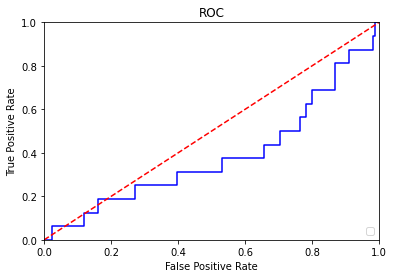

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 2, validation accuracy is 0.09542731921110299
training on epoch: 2, validation KS is 0.1024408284023669
training on epoch: 2, validation AUC is 0.5262573964497042
balance_status of validation set have 0.08648648648648649 of ones in val


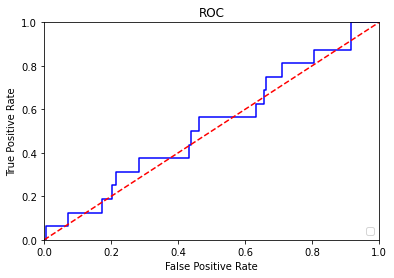

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 4, validation accuracy is 0.1937764791818846
training on epoch: 4, validation KS is 0.19785502958579881
training on epoch: 4, validation AUC is 0.5665680473372781
balance_status of validation set have 0.08648648648648649 of ones in val


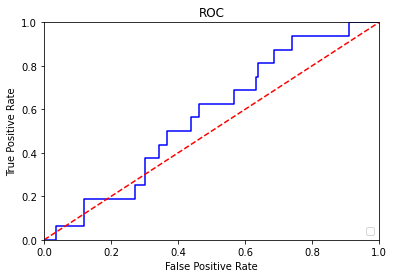

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 6, validation accuracy is 0.2742439737034332
training on epoch: 6, validation KS is 0.26886094674556216
training on epoch: 6, validation AUC is 0.5702662721893491
balance_status of validation set have 0.08648648648648649 of ones in val


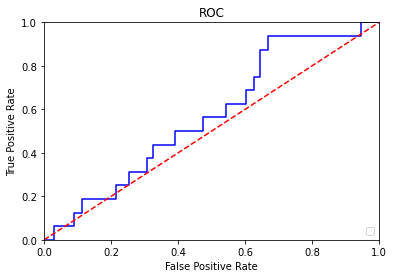

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 8, validation accuracy is 0.2697735573411249
training on epoch: 8, validation KS is 0.18602071005917165
training on epoch: 8, validation AUC is 0.5673076923076923
balance_status of validation set have 0.08648648648648649 of ones in val


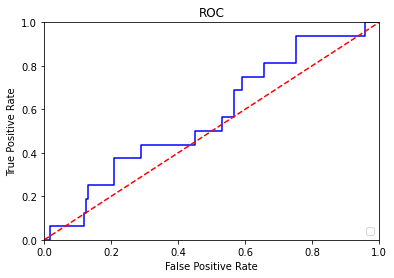

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 10, validation accuracy is 0.24295105916727538
training on epoch: 10, validation KS is 0.3206360946745562
training on epoch: 10, validation AUC is 0.6042899408284024
balance_status of validation set have 0.08648648648648649 of ones in val


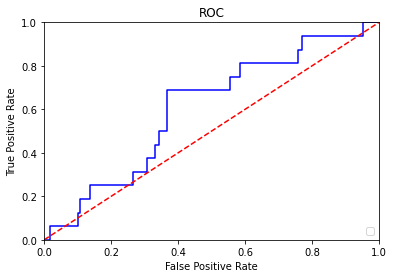

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 12, validation accuracy is 0.24295105916727538
training on epoch: 12, validation KS is 0.3443047337278107
training on epoch: 12, validation AUC is 0.6183431952662722
balance_status of validation set have 0.08648648648648649 of ones in val


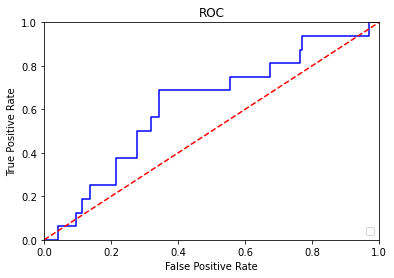

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 14, validation accuracy is 0.26530314097881663
training on epoch: 14, validation KS is 0.3206360946745562
training on epoch: 14, validation AUC is 0.6161242603550295
balance_status of validation set have 0.08648648648648649 of ones in val


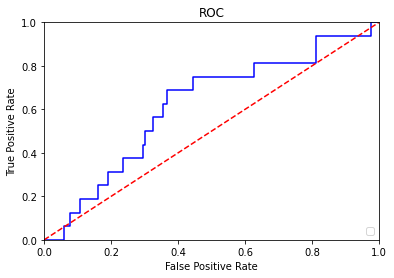

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 16, validation accuracy is 0.25636230825420014
training on epoch: 16, validation KS is 0.34097633136094674
training on epoch: 16, validation AUC is 0.6246301775147929
balance_status of validation set have 0.08648648648648649 of ones in val


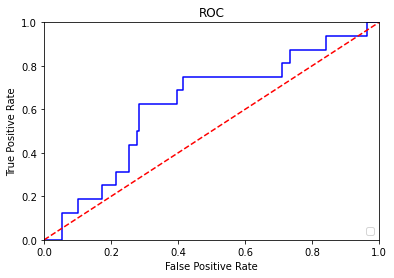

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 18, validation accuracy is 0.2742439737034332
training on epoch: 18, validation KS is 0.29363905325443784
training on epoch: 18, validation AUC is 0.6083579881656804
balance_status of validation set have 0.08648648648648649 of ones in val


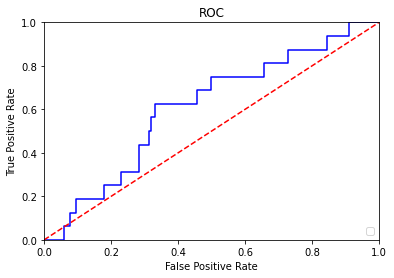

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 20, validation accuracy is 0.32341855368882394
training on epoch: 20, validation KS is 0.27588757396449703
training on epoch: 20, validation AUC is 0.6013313609467456
balance_status of validation set have 0.08648648648648649 of ones in val


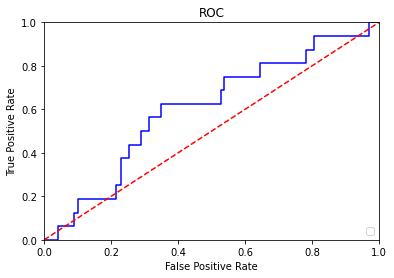

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 22, validation accuracy is 0.28765522279035793
training on epoch: 22, validation KS is 0.3291420118343195
training on epoch: 22, validation AUC is 0.613905325443787
balance_status of validation set have 0.08648648648648649 of ones in val


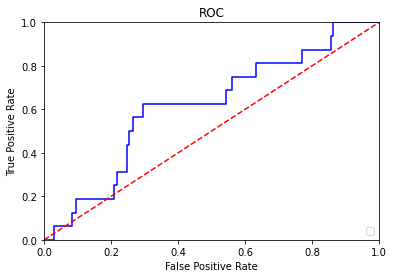

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 24, validation accuracy is 0.3189481373265157
training on epoch: 24, validation KS is 0.2640532544378698
training on epoch: 24, validation AUC is 0.6020710059171598
balance_status of validation set have 0.08648648648648649 of ones in val


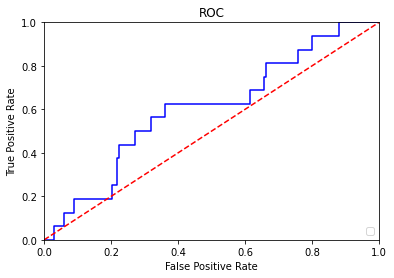

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 26, validation accuracy is 0.34577063550036524
training on epoch: 26, validation KS is 0.27255917159763315
training on epoch: 26, validation AUC is 0.6005917159763313
balance_status of validation set have 0.08648648648648649 of ones in val


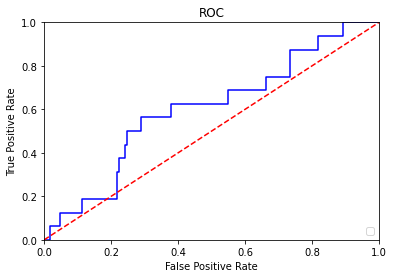

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 28, validation accuracy is 0.394945215485756
training on epoch: 28, validation KS is 0.21338757396449703
training on epoch: 28, validation AUC is 0.5813609467455622
balance_status of validation set have 0.08648648648648649 of ones in val


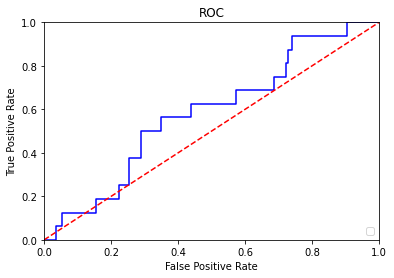

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 30, validation accuracy is 0.4172972972972973
training on epoch: 30, validation KS is 0.26072485207100593
training on epoch: 30, validation AUC is 0.5891272189349113
balance_status of validation set have 0.08648648648648649 of ones in val


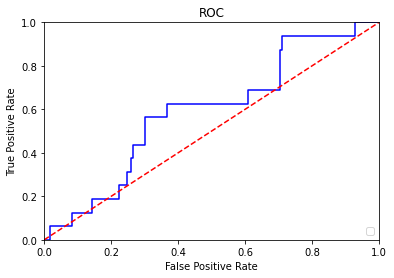

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 32, validation accuracy is 0.47094229364499635
training on epoch: 32, validation KS is 0.20968934911242598
training on epoch: 32, validation AUC is 0.5706360946745561
balance_status of validation set have 0.08648648648648649 of ones in val


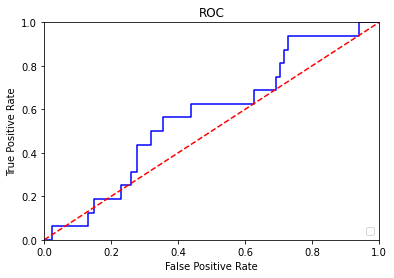

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 34, validation accuracy is 0.5558802045288532
training on epoch: 34, validation KS is 0.19785502958579881
training on epoch: 34, validation AUC is 0.558801775147929
balance_status of validation set have 0.08648648648648649 of ones in val


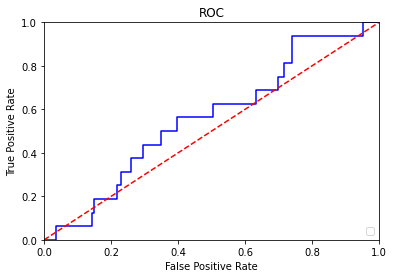

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 36, validation accuracy is 0.605054784514244
training on epoch: 36, validation KS is 0.17455621301775148
training on epoch: 36, validation AUC is 0.5580621301775148
balance_status of validation set have 0.08648648648648649 of ones in val


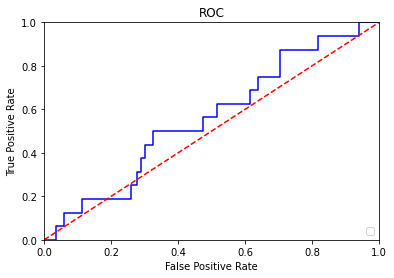

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 38, validation accuracy is 0.6139956172388605
training on epoch: 38, validation KS is 0.18047337278106507
training on epoch: 38, validation AUC is 0.555103550295858
balance_status of validation set have 0.08648648648648649 of ones in val


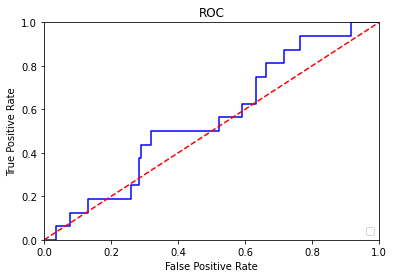

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 40, validation accuracy is 0.6497589481373265
training on epoch: 40, validation KS is 0.15754437869822485
training on epoch: 40, validation AUC is 0.5573224852071006
balance_status of validation set have 0.08648648648648649 of ones in val


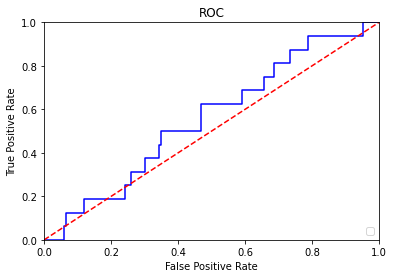

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 42, validation accuracy is 0.658699780861943
training on epoch: 42, validation KS is 0.17677514792899407
training on epoch: 42, validation AUC is 0.5599112426035503
balance_status of validation set have 0.08648648648648649 of ones in val


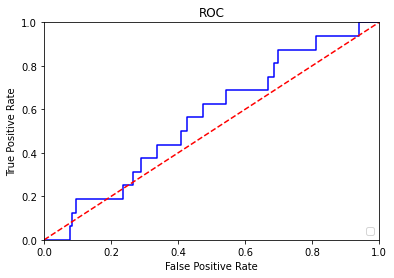

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 44, validation accuracy is 0.6989335281227174
training on epoch: 44, validation KS is 0.19785502958579881
training on epoch: 44, validation AUC is 0.5617603550295858
balance_status of validation set have 0.08648648648648649 of ones in val


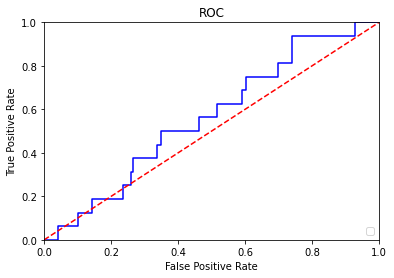

------------generate form-------------------------------------------
--------------------------------------------------------------------


In [ ]:
test_model.training(epochs=100,batch_size=1000,show_epoch=2,data=data,data_non=data_non_seq,label=train_Y\
                   ,val_seq=val_seq,val_non=val_non,val_Y=val_Y)

In [ ]:

test_seq,test_non,test_Y=test
test_seq=non_onehot(test_seq,14)
test_Y=(t.fit_transform(test_Y[:,np.newaxis])).todense()
test_seq.shape,test_non.shape,test_Y.shape


In [ ]:
# YY_prob.shape

In [ ]:
# YY_prob=test_model.non_sequential_NN.predict(test_non)
# np.sum(YY_prob,axis=-1)

In [ ]:
# np.sum(YY_prob)

In [ ]:
73338.695

In [ ]:
# YL_prob=test_model.LSTM.predict(test_seq)
# np.sum(YL_prob,axis=-1)

In [ ]:
# np.sum(YL_prob)

## you can now read the saved model

In [ ]:
model_saved=keras.models.load_model("../../data/models/binary_classification_model/"+"embedding_LSTM_FC1_show1_epoch64.h5")

In [ ]:
k=test_model.transform_used(500,data_used=test_seq,data_non=test_non,label=train_Y,\
                            random_or_not=False,train=False)
store=[]
for i in range(len(test_seq)//500+(len(test_seq)%500!=0)):
    test_dataset=next(k)
    d0=test_dataset[0]
    d1=test_dataset[1]
    d2=test_dataset[2]
    test_predict_prob=model_saved.predict([d0,d1,d2])
    store.append(test_predict_prob)
store=np.concatenate(store,axis=0)
test_predict_prob=store
test_predict=np.argmax(test_predict_prob,axis=-1)
acc=np.mean(test_predict==test_Y[:,1])
test_ks=get_KS(test_predict_prob[:,1],test_Y[:,1])
acc,test_ks

In [ ]:
fpr,tpr,threshold=roc_curve(test_Y[:,1],test_predict_prob[:,1])
val_auc=auc(fpr,tpr)
val_auc

In [ ]:
fpr, tpr, threshold = roc_curve(test_Y[:,1],test_predict_prob[:,1])                
plt.title('ROC')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
